In [1]:
import requests, json, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import requests

## Load Divvy Data

In [2]:
# used for the initial load - helpful to export to pickle after and load from next cell
# downloaded from https://www.divvybikes.com/system-data
ride_df = pd.read_csv('~/Downloads/Divvy_Trips.csv')



# cleaning

# lowercase the columns
ride_df.columns = [x.lower().replace(' ','_') for x in ride_df.columns]

# print the shape of data
print(f'data before cleaning: {ride_df.shape}')

# drop unneccesary columns
# ride_df.drop(['from_location','to_location'],axis=1, inplace=True)

# convert 'start' to datetime
ride_df['start_time'] = pd.to_datetime(ride_df['start_time'])

# add a date only column
ride_df['date'] = ride_df['start_time'].dt.date

# print shape after cleaning
print(f'data after cleaning: {ride_df.shape}')

# filter for summer '19
startdate = pd.to_datetime("2019-6-15").date()
enddate = pd.to_datetime("2019-10-15").date()

In [3]:
# # used if you have already pickled from above ^^
# ride_df = pd.read_pickle('ride_df_pickle')

 --------------

### Grouping Dataframes

In [4]:
# total rides per date
day_rides_df = ride_df.groupby(['date']).agg({'trip_id': 'count'}).reset_index()

# total rides per date, with subset of membership type
day_sub_df = ride_df.groupby(['date','user_type']).agg({'trip_id': 'count'}).reset_index()

# total rides per station
station_rides = ride_df.groupby(['from_station_name']).agg({'trip_id':'count'}).reset_index()

# total rides per station per day
ride_grouped_stations = ride_df.groupby(['from_station_name',
                                         'date']).agg({'trip_id':'count',
                                                       'from_latitude':'max',
                                                       'from_longitude':'max'}).reset_index()
ride_grouped_stations = ride_grouped_stations.rename(columns={'trip_id': 'total_rides'})

 --------------

## Load the weather Data

In [5]:
# weather was downloaded from Open Weather Map

# open weather map
weather_df = pd.read_pickle('chicago_weather')

# remove UTC from datetime
weather_df['dt_iso'] = weather_df['dt_iso'].map(lambda x: x[:-4])

# convert to datetime
weather_df['dt_iso'] = pd.to_datetime(weather_df.dt_iso, utc=True)

# convert to central time
weather_df['dt_iso'] = pd.DatetimeIndex(weather_df['dt_iso']).tz_convert('US/Central')

# add a date column
weather_df['date'] = weather_df.dt_iso.dt.date

# convert to farenheight
weather_df['temp'] = weather_df['temp'] * (9/5) +32

# set columns to drop
col_to_drop = ['dt','lat','lon','pressure','sea_level','grnd_level','rain_12h','rain_today','snow_12h','snow_today']

# drop most columns ^
weather_df.drop(col_to_drop,axis=1,inplace=True)

### Create the 'bad weather' df

In [6]:
# show the types of weather
print(weather_df.weather_main.unique())
bad_weather_lst = ['Rain','Thunderstorm','Snow']

['Clouds' 'Snow' 'Clear' 'Rain' 'Mist' 'Drizzle' 'Fog' 'Haze'
 'Thunderstorm' 'Smoke' 'Tornado' 'Dust']


In [7]:
# create a dataframe of bad weather days
rain_df = weather_df[weather_df['weather_main'].isin(bad_weather_lst)]
rain_df = rain_df.groupby('date').agg({'dt_iso':'count'})
rain_df['bad_weather'] = 1

rain_final = rain_df.drop('dt_iso', axis=1).reset_index()

### Create the 'temperature' df

In [8]:
temp_df = weather_df.groupby('date').agg({'temp':'mean'}).reset_index()
temp_df.sample()

,date,temp
1156,2014-01-29,13.121


 --------------

# Open and merge weather data

### Weather Rides

In [9]:
# merge weather with total daily rides
rides_weather = pd.merge(day_rides_df,rain_final,on='date',how='left')

# fill na values
rides_weather['bad_weather'] = rides_weather['bad_weather'].fillna(0)

# rename the trip_id column
rides_weather.rename(columns={'trip_id': 'num_rides'}, inplace=True)

In [10]:
rides_weather.sample(2)

,date,num_rides,bad_weather
752,2018-09-23,13542,0.0
196,2017-03-16,4989,0.0


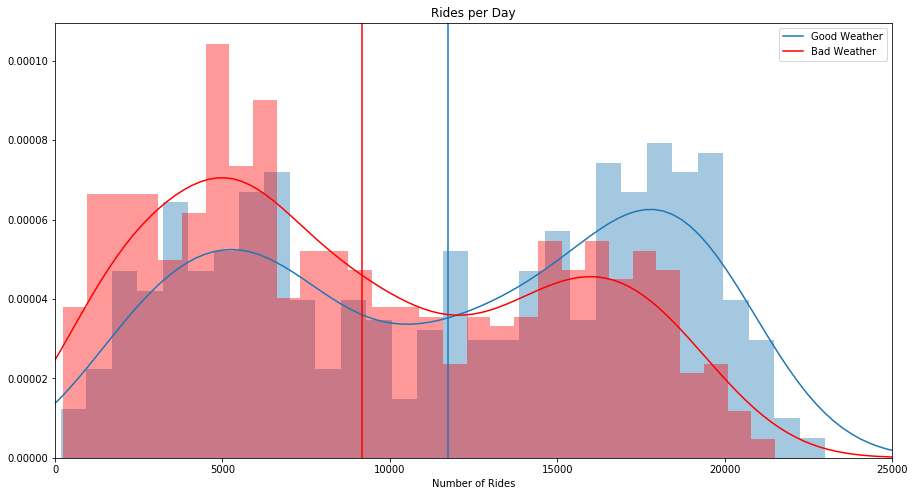

In [11]:
# plot bad weather rides
plt.figure(figsize=(15,8))
sns.distplot(rides_weather[rides_weather['bad_weather'] == 0]['num_rides'], bins=30)
plt.axvline(rides_weather[rides_weather['bad_weather'] == 0]['num_rides'].mean())
sns.distplot(rides_weather[rides_weather['bad_weather'] == 1]['num_rides'], color='red',bins=30)
plt.axvline(rides_weather[rides_weather['bad_weather'] == 1]['num_rides'].mean(), color='red')
plt.title('Rides per Day')
plt.xlabel('Number of Rides')
plt.legend(labels=['Good Weather', 'Bad Weather'])
plt.xlim(0,25000);

In [12]:
from math import sqrt

x_bar = 9152.618487
n = 595
sigma = 6097.681347817574
mu = 10372.192888888889

# z, p, and confidence score for normal to bad days
z = (x_bar - mu)/(sigma/sqrt(n))
print(f'z-score: {z}')
p = stats.norm.cdf(z)
print(f'p-value: {p}')
confidence = 1 - stats.norm.cdf(z)
print(f'confidence: {confidence}')

z-score: -4.878676908221245
p-value: 5.339992296507048e-07
confidence: 0.9999994660007704


 --------------

### Membership Segmentation

In [13]:
# merge weather with total rides grouped by membership
mem_rides_weather = pd.merge(day_sub_df,rain_final,on='date',how='left')

# fill na values
mem_rides_weather['bad_weather'] = mem_rides_weather['bad_weather'].fillna(0)

# rename the trip_id column
mem_rides_weather.rename(columns={'trip_id': 'num_rides'}, inplace=True)

In [14]:
cust_rides = mem_rides_weather.query('user_type == "Customer"')
cust_mean = cust_rides.query('bad_weather == 1').num_rides.mean()
print(f'Customer average rides per day: {cust_mean}')

sub_rides = mem_rides_weather.query('user_type == "Subscriber"')
sub_mean = sub_rides.query('bad_weather == 1').num_rides.mean()
print(f'Subscriber average rides per day: {sub_mean}')

Customer average rides per day: 1824.5378151260504
Subscriber average rides per day: 7328.065546218488


In [15]:
# creating bad weather dataframes segmented by rider type
bad_weather_df = mem_rides_weather[mem_rides_weather['bad_weather'] == 1]
bad_customers = bad_weather_df[bad_weather_df['user_type'] == 'Customer']
bad_subs = bad_weather_df[bad_weather_df['user_type'] == 'Subscriber']

# creating good weather dataframes segmented by rider type
good_weather_df = mem_rides_weather[mem_rides_weather['bad_weather'] == 0]
good_customers = good_weather_df[good_weather_df['user_type'] == 'Customer']
good_subs = good_weather_df[good_weather_df['user_type'] == 'Subscriber']

In [16]:
bad = bad_customers['num_rides']
good = good_customers['num_rides']

t_stat, p_value = stats.ttest_ind(good, bad)
print(f'customer t-stat: {t_stat}')
print(f'customer p-value: {p_value}')

customer t-stat: 5.729594721768127
customer p-value: 1.2920796648352065e-08


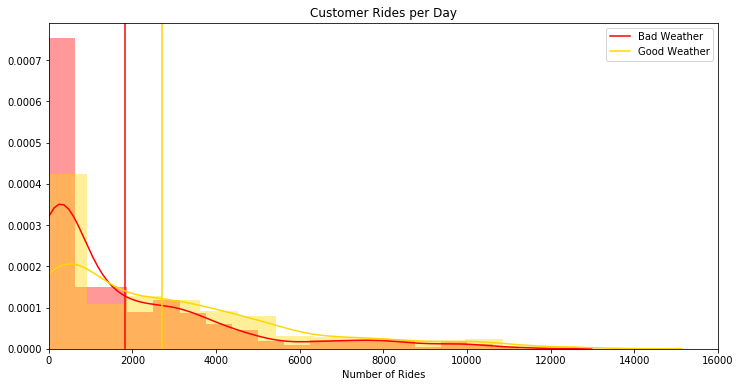

In [17]:
#Customers vs Weather'
plt.figure(figsize=(12,6))
sns.distplot(bad, color='red')
plt.axvline(bad.mean(),color='red')
sns.distplot(good, color='gold')
plt.axvline(good.mean(), color='gold')
plt.title('Customer Rides per Day')
plt.xlabel('Number of Rides')
plt.legend(labels=['Bad Weather', 'Good Weather'])
plt.xlim(0);

In [18]:
bad2 = bad_subs['num_rides']
good2 = good_subs['num_rides']

t_stat, p_value = stats.ttest_ind(good2, bad2)
print(f'subscriber t-stat: {t_stat}')
print(f'subscriber p-value: {p_value}')

subscriber t-stat: 6.655630886951399
subscriber p-value: 4.401206767023926e-11


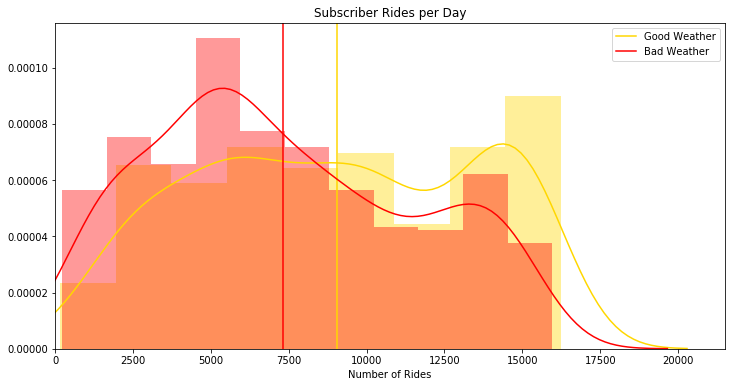

In [19]:
#Subs vs Weather
plt.figure(figsize=(12,6))
sns.distplot(good2, color='gold')
plt.axvline(good2.mean(), color='gold')
sns.distplot(bad2, color='red')
plt.axvline(bad2.mean(),color='red')
plt.title('Subscriber Rides per Day')
plt.xlabel('Number of Rides')
plt.legend(labels=['Good Weather', 'Bad Weather'])
plt.xlim(0);

 --------------

### Temperature

In [20]:
# merge weather with membership rides
rides_temp_df = pd.merge(day_rides_df,temp_df,on='date',how='left')
rides_temp_df = rides_temp_df.rename(columns = {'trip_id':'rides'})
print(rides_temp_df.sample())

           date  rides    temp
134  2017-01-13   3676  23.486


In [21]:
def temp_bins(x):
    
    temp_bins = ['-0','0+','10+','20+','30+','40+','50+','60+','70+','80+','90+','100+']
    
    for i,n in enumerate(range(0,110,10)):
        if x < n:
            return temp_bins[i]

In [22]:
# bin the temps
rides_temp_bin_df = rides_temp_df.copy()
rides_temp_bin_df['temp_bins'] = rides_temp_df['temp'].map(lambda x: temp_bins(x))

In [23]:
left_bound = 736115
right_bound = 737424

In [24]:
# reading datetime with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

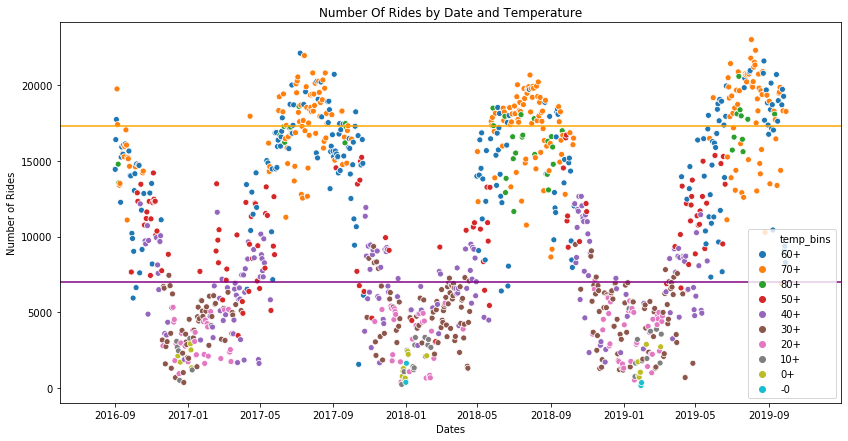

In [25]:
plt.figure(figsize=(14,7))
sns.scatterplot('date','rides',data=rides_temp_bin_df, hue='temp_bins');
plt.hlines([17297,7028],736115,737424,colors=['orange', 'purple']);
# sns.boxplot('temp', 'counts', data=ride_temp_df);
plt.xlim(left_bound,right_bound)
plt.xlabel('Dates');
plt.ylabel('Number of Rides');
plt.title('Number Of Rides by Date and Temperature');

In [26]:
rides_temp_df

,date,rides,temp
0,2016-09-01,14435,68.368250
1,2016-09-02,16399,68.575250
2,2016-09-03,17729,68.128250
3,2016-09-04,19744,70.089500
4,2016-09-05,17386,77.168750
...,...,...,...
1120,2019-09-26,19256,64.700750
1121,2019-09-27,9091,63.759200
1122,2019-09-28,9362,60.701310
1123,2019-09-29,8282,63.558846


In [27]:
lr = ols('rides~temp',data = rides_temp_df).fit()

In [28]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     3981.
Date:                Sun, 02 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:08:03   Log-Likelihood:                -10549.
No. Observations:                1125   AIC:                         2.110e+04
Df Residuals:                    1123   BIC:                         2.111e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3968.5896    242.774    -16.347      0.000   -4444.931   -3492.248
temp         273.6792      4.338     63.095      0.000     265.168     282.190
==============================================================================
Omnibus:                       16.677   Durbin-Watson:                   1.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.245
Skew:                          -0.301   Prob(JB):                     0.000180
Kurtosis:                       2.928   Cond. No.                         159.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

_______

### Daily customer temp df

In [29]:
# merge weather with membership rides
rides_temp_mem_df = pd.merge(day_sub_df,temp_df,on='date',how='left')
print(rides_temp_mem_df.head(2))

         date   user_type  trip_id      temp
0  2016-09-01    Customer     1841  68.36825
1  2016-09-01  Subscriber    12594  68.36825


In [30]:
temp_df

,date,temp
0,2010-11-30,27.95900
1,2010-12-01,24.83375
2,2010-12-02,28.00625
3,2010-12-03,27.58700
4,2010-12-04,29.98100
...,...,...
3292,2019-12-05,37.64075
3293,2019-12-06,35.06000
3294,2019-12-07,32.00075
3295,2019-12-08,41.47400


In [31]:
# merge with temp
ride_grouped_stations = pd.merge(ride_grouped_stations,rides_temp_bin_df, on='date',how='left')

In [32]:
ride_grouped_stations.rename(columns={'temp_x':'temp', 'temp_y':'temp_bins'}, inplace=True)

---

### Looking at days of the week

In [33]:
# convert to datetime
ride_grouped_stations['date'] = pd.to_datetime(ride_grouped_stations['date'])

# add day of week
ride_grouped_stations['day'] = ride_grouped_stations.date.dt.dayofweek

# function to tell if weekend
def weekend(x):
    if x in ([6,5]):
        return 'Weekend'
    else:
        return 'Weekday'

# applying function to dataframe
ride_grouped_stations['day'] = ride_grouped_stations['day'].map(lambda x: weekend(x))

In [34]:
# subset dataframes to only specific stations
streeter_grand = ride_grouped_stations.query('from_station_name == "Streeter Dr & Grand Ave"')
streeter_grand = streeter_grand.sort_values('temp',ascending=False)
clinton_washington = ride_grouped_stations.query('from_station_name == "Clinton St & Washington Blvd"')
clinton_washington = clinton_washington.sort_values('temp', ascending=False)


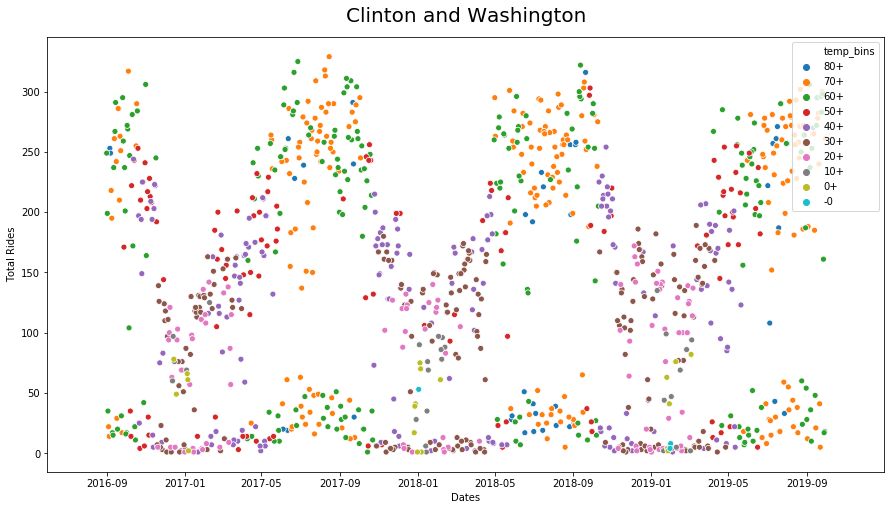

In [35]:
plt.figure(figsize=(15,8))
sns.scatterplot('date', 'total_rides', data=clinton_washington,hue='temp_bins')
plt.title('Clinton and Washington',fontdict={'fontsize':20},pad=15)
plt.legend(loc='upper right')
plt.xlabel('Dates')
plt.ylabel('Total Rides')
plt.xlim(left_bound, right_bound);


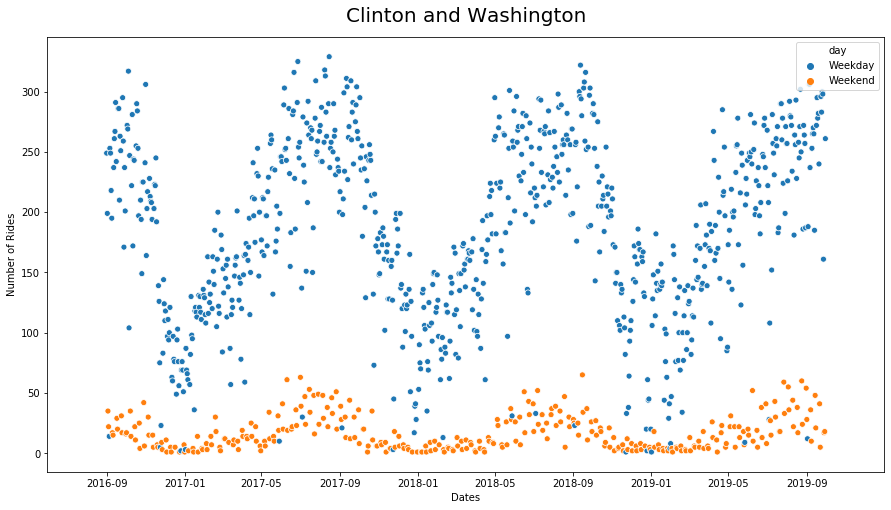

In [36]:
# show rides by day of week - commuter station
plt.figure(figsize=(15,8))
sns.scatterplot('date', 'total_rides', data=clinton_washington.sort_values('date'),hue='day')
plt.title('Clinton and Washington',fontdict={'fontsize':20},pad=15)
plt.legend(loc='upper right')
plt.xlabel('Dates')
plt.ylabel('Number of Rides')
plt.xlim(left_bound, right_bound);

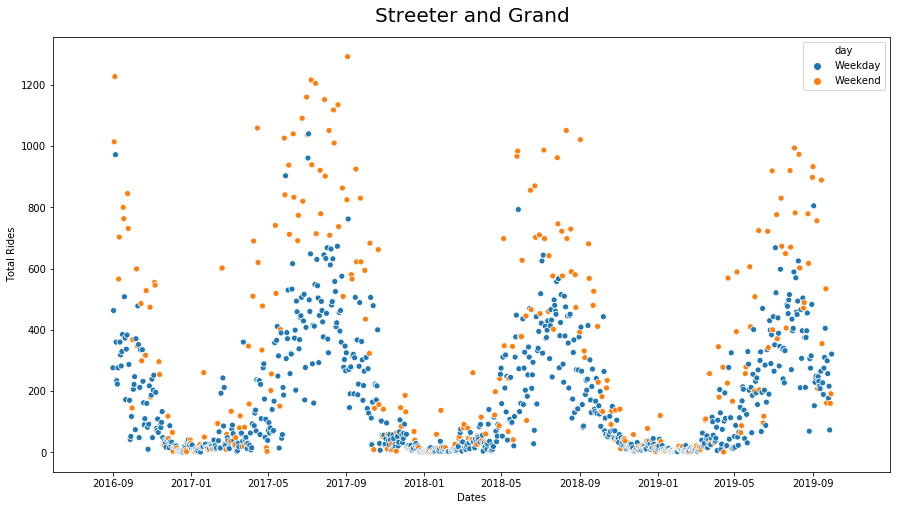

In [37]:
# show rides by day of week - visitor station
plt.figure(figsize=(15,8))
sns.scatterplot('date', 'total_rides', data=streeter_grand.sort_values('date'),hue='day')
plt.legend(loc='upper right')
plt.xlabel('Dates')
plt.ylabel('Total Rides')
plt.title('Streeter and Grand',fontdict={'fontsize':20},pad=15)
plt.xlim(left_bound, right_bound);

In [38]:
# create list of stations without density of 4+ rides per day
stations_to_drop = list(station_rides.query('trip_id < 3375')['from_station_name'])

In [39]:
# creating dataframe to run tests on
print(f'number of stations before dropping stations: {ride_grouped_stations.from_station_name.nunique()}')

over_2000 = ride_grouped_stations[~ride_grouped_stations['from_station_name'].isin(stations_to_drop)].copy()

print(f'number of stations after dropping stations: {over_2000.from_station_name.nunique()}')

print(f'stations dropped: {696 - 488}')

number of stations before dropping stations: 696
number of stations after dropping stations: 441
stations dropped: 208


In [40]:
over_2000['dow'] = over_2000.date.dt.dayofweek

In [41]:
over_2000 = pd.get_dummies(over_2000,columns=['dow'])

In [42]:
over_2000

,from_station_name,date,total_rides,from_latitude,from_longitude,rides,temp,temp_bins,day,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
1470,900 W Harrison St,2016-09-01,26,41.874675,-87.650019,14435,68.368250,60+,Weekday,0,0,0,1,0,0,0
1471,900 W Harrison St,2016-09-02,29,41.874675,-87.650019,16399,68.575250,60+,Weekday,0,0,0,0,1,0,0
1472,900 W Harrison St,2016-09-03,8,41.874675,-87.650019,17729,68.128250,60+,Weekend,0,0,0,0,0,1,0
1473,900 W Harrison St,2016-09-04,5,41.874675,-87.650019,19744,70.089500,70+,Weekend,0,0,0,0,0,0,1
1474,900 W Harrison St,2016-09-05,12,41.874675,-87.650019,17386,77.168750,70+,Weekday,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525564,Woodlawn Ave & Lake Park Ave,2019-09-26,7,41.814093,-87.597005,19256,64.700750,60+,Weekday,0,0,0,1,0,0,0
525565,Woodlawn Ave & Lake Park Ave,2019-09-27,6,41.814093,-87.597005,9091,63.759200,60+,Weekday,0,0,0,0,1,0,0
525566,Woodlawn Ave & Lake Park Ave,2019-09-28,4,41.814093,-87.597005,9362,60.701310,60+,Weekend,0,0,0,0,0,1,0
525567,Woodlawn Ave & Lake Park Ave,2019-09-29,3,41.814093,-87.597005,8282,63.558846,60+,Weekend,0,0,0,0,0,0,1


In [43]:
#  TRUE ONE

def run_day_ols(df):
    
    '''
    input: dataframe of rides per day per station
    output: dataframe of stations pvalues of 
    '''
    
    stations = list(df.from_station_name.unique())
    dow = list(over_2000.iloc[:, -7:].columns)
    
    table = []
    predictor = '+'.join(dow)
    outcome = 'rides'
    
    f = outcome+'~'+predictor
    
    for station in stations:
        df = over_2000[over_2000['from_station_name'] == station]
        station_var = ols(formula=f, data=df).fit()
        df = sm.stats.anova_lm(station_var)
        d_pvalues = [df['PR(>F)'][i] for i, day in enumerate(dow)]
        dic = {'station':station}
        for i in d_pvalues:
            for x in dow:
                dic[x] = i
        table.append(dic)
        
    df = pd.DataFrame(table)
    df.columns = ['station','mon','tue','wed','thu','fri','sat','sun']
        
    return df

In [44]:
day_ols_df = run_day_ols(over_2000)
day_ols_df

,station,mon,tue,wed,thu,fri,sat,sun
0,900 W Harrison St,0.719974,0.719974,0.719974,0.719974,0.719974,0.719974,0.719974
1,Aberdeen St & Jackson Blvd,0.719051,0.719051,0.719051,0.719051,0.719051,0.719051,0.719051
2,Aberdeen St & Monroe St,0.378429,0.378429,0.378429,0.378429,0.378429,0.378429,0.378429
3,Aberdeen St & Randolph St,0.729177,0.729177,0.729177,0.729177,0.729177,0.729177,0.729177
4,Ada St & Washington Blvd,0.824413,0.824413,0.824413,0.824413,0.824413,0.824413,0.824413
...,...,...,...,...,...,...,...,...
436,Wood St & Hubbard St,0.518829,0.518829,0.518829,0.518829,0.518829,0.518829,0.518829
437,Wood St & Milwaukee Ave,0.631021,0.631021,0.631021,0.631021,0.631021,0.631021,0.631021
438,Wood St & Taylor St,0.393715,0.393715,0.393715,0.393715,0.393715,0.393715,0.393715
439,Woodlawn Ave & 55th St,0.273355,0.273355,0.273355,0.273355,0.273355,0.273355,0.273355


In [45]:
def station_temp_ttest(df):
    
    '''
    input: dataframe of rides per day per station
    output: dataframe of stations with t and p values for temperature
    '''
    
    stations = list(df.from_station_name.unique())
    table = []
    
    for station in stations:
        df = over_2000[over_2000['from_station_name'] == station]
        
        t_stat, p_value = stats.ttest_ind(df['total_rides'], df['temp'])
        
        dic = {'station':station, 't_stat': t_stat, 'p_value': p_value}
        
        table.append(dic)
        
    df = pd.DataFrame(table)
    
    return df

    

In [46]:
station_t_test_df = station_temp_ttest(over_2000)

In [47]:
station_t_test_df

,station,t_stat,p_value
0,900 W Harrison St,-54.211319,0.000000e+00
1,Aberdeen St & Jackson Blvd,-27.687667,2.549362e-145
2,Aberdeen St & Monroe St,-34.258444,3.150206e-207
3,Aberdeen St & Randolph St,-24.232227,8.805650e-103
4,Ada St & Washington Blvd,-43.500671,1.398924e-299
...,...,...,...
436,Wood St & Hubbard St,-68.196392,0.000000e+00
437,Wood St & Milwaukee Ave,-28.950717,1.005703e-156
438,Wood St & Taylor St,-52.608418,0.000000e+00
439,Woodlawn Ave & 55th St,-73.130540,0.000000e+00


## Create a heatmap of the ridership

In [48]:
import folium
from folium import plugins
from folium.plugins import HeatMap

chicago_coords = [41.908254, -87.694986]

In [49]:
ride_df['dow'] = ride_df['start_time'].dt.dayofweek
ride_df['dow'] = ride_df['dow'].map(lambda x: weekend(x))

In [50]:
counts = ride_df.groupby(['from_latitude','from_longitude']).agg({'trip_id':'count'}).reset_index()

In [51]:
lst = list(zip(counts['from_latitude'], counts['from_longitude'], counts['trip_id']))

In [52]:
coords = [[x[0],x[1],x[2]] for x in lst]

In [53]:
base_map = folium.Map(chicago_coords,
                      zoom_start=11, tiles='stamentoner')

# create heatmap
HeatMap(coords,radius=8, min_opacity=.1).add_to(base_map)

base_map